In [1]:
%matplotlib inline

In [2]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn
import sklearn.linear_model
from datetime import datetime, date
import warnings
import timeit
from collections import defaultdict, OrderedDict
import time
from IPython.display import display
import scipy
from scipy import stats
import pystan

timeit.template = """
def inner(_it, _timer{init}):
    {setup}
    _t0 = _timer()
    for _i in _it:
        retval = {stmt}
    _t1 = _timer()
    return _t1 - _t0, retval
"""

matplotlib.style.use('ggplot')

RANDOM_SEED = 33

## Load and clean the data

In [3]:
DATE_FORMAT = r'%d/%m/%Y'

mauna_loa = pandas.read_csv(r'./weekly_in_situ_co2_mlo_data_only.csv')
first_day = datetime.strptime(mauna_loa['ds'][0], r'%d/%m/%Y')
mauna_loa['day'] = [(datetime.strptime(date_string, DATE_FORMAT) - first_day).days
                    for date_string in mauna_loa['ds']]

day_range = max(mauna_loa['day']) - min(mauna_loa['day'])
mauna_loa['norm_day'] = mauna_loa['day'] / day_range * 2

y_min = min(mauna_loa['y'])
y_range = max(mauna_loa['y']) - y_min
mauna_loa['norm_y'] = (mauna_loa['y'] - y_min)/ y_range

mauna_loa.head()

,ds,y,day,norm_day,norm_y
0,29/03/1958,316.19,0,0.000000,0.032427
1,05/04/1958,317.31,7,0.000643,0.043957
2,12/04/1958,317.69,14,0.001286,0.047869
3,19/04/1958,317.58,21,0.001929,0.046737
4,26/04/1958,316.48,28,0.002572,0.035413


In [4]:
min(mauna_loa['norm_y']), max(mauna_loa['norm_y']), min(mauna_loa['norm_day']), max(mauna_loa['norm_day'])

(0.0, 1.0, 0.0, 2.0)

In [ ]:
2 * np.pi / (365.25 / day_range)

In [ ]:
mauna_loa.to_csv('./cleaned_mauna_loa_data.csv')

In [ ]:
mauna_loa.plot(x='norm_day', y='norm_y', figsize=(12, 8))

In [ ]:
from pandas.plotting import autocorrelation_plot, lag_plot

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(mauna_loa['norm_y'], ax)

In [ ]:
y_diffs = [y - x for x, y in zip(mauna_loa['norm_y'], mauna_loa['norm_y'][1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(y_diffs, ax)

In [ ]:
second_diffs = [y - x for x, y in zip(y_diffs, y_diffs[1:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(second_diffs, ax)

In [ ]:
t_diffs = [y - x for x, y in zip(y_diffs, y_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t_diffs, ax)

In [ ]:
t2_diffs = [y - x for x, y in zip(t_diffs, t_diffs[52:])] 
fig = plt.figure(figsize=(12, 8))
ax = fig.gca()
autocorrelation_plot(t2_diffs, ax)

In [ ]:
corr = np.correlate(t_diffs, t_diffs, 'same')
half_corr = corr[corr.shape[0] // 2:]
fig = plt.figure(figsize=(12, 8))
plt.plot(half_corr)

In [ ]:
np.argmax(half_corr[1:])

In [ ]:
import statsmodels.api as sm

dta = sm.datasets.co2.load_pandas().data
# deal with missing values. see issue
dta.co2.interpolate(inplace=True)

res = sm.tsa.seasonal_decompose(dta.co2)

fig = plt.figure(figsize=(12, 8))
resplot = res.plot()

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.trend)

In [ ]:
fig = plt.figure(figsize=(12, 8))
plt.plot(res.seasonal[:200])

In [5]:
def assymetric_triangle_wave(alpha, omega, phi, min_point, x_values):
    x_values = np.asarray(x_values)
    y_values = []
    x_mod = (x_values * omega + phi) % (2 * np.pi)
    
    for x in x_mod:
        if x < min_point:
            y_values.append(1 - 2 * x / min_point)
        else:
            y_values.append((2*x  - min_point - 2 * np.pi) / (2 * np.pi - min_point))
            
    return np.asarray(y_values) * alpha
    

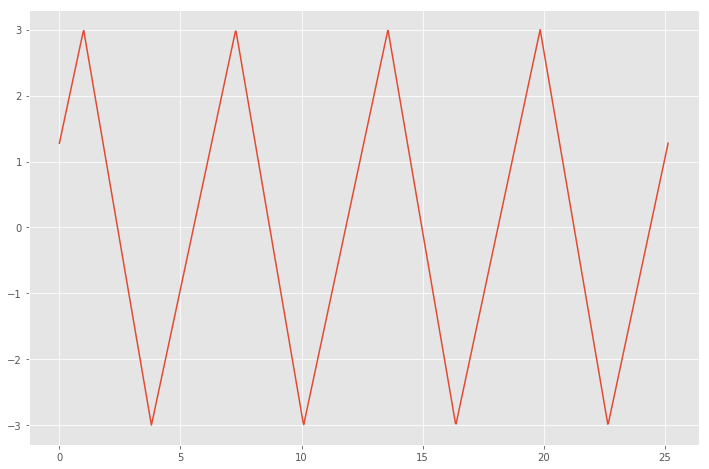

In [6]:
x_tri = np.linspace(0, 8 * np.pi, 1000)
y_tri = assymetric_triangle_wave(3, 1, -1, 2.8, x_tri)

plt.figure(figsize=(12, 8))
plt.plot(x_tri, y_tri)


In [7]:
import pickle
samples = None
with open('model_samples.pickle', 'rb') as out_file:
    samples = pickle.load(out_file)
    
samples.keys()

odict_keys(['b', 'unbound_omega', 'phi_x', 'phi_y', 'unbound_alpha', 'unbound_sigma_y', 'phi', 'alpha', 'sigma_y', 'y_simulated_train', 'y_future', 'lp__'])

In [8]:
# TRAIN_SIZE = 1040
# TEST_SIZE = 1040
# train = mauna_loa[:TRAIN_SIZE]
# test = mauna_loa[TRAIN_SIZE:TRAIN_SIZE + TEST_SIZE]

TEST_SIZE = 0.25
N = len(mauna_loa)

train = mauna_loa[:int(-N * TEST_SIZE)]
test = mauna_loa[int(-N * TEST_SIZE):]
len(mauna_loa), len(train), len(test)

(3040, 2280, 760)

In [9]:
residuals = samples['y_simulated_train'] - train['norm_y'].as_matrix()

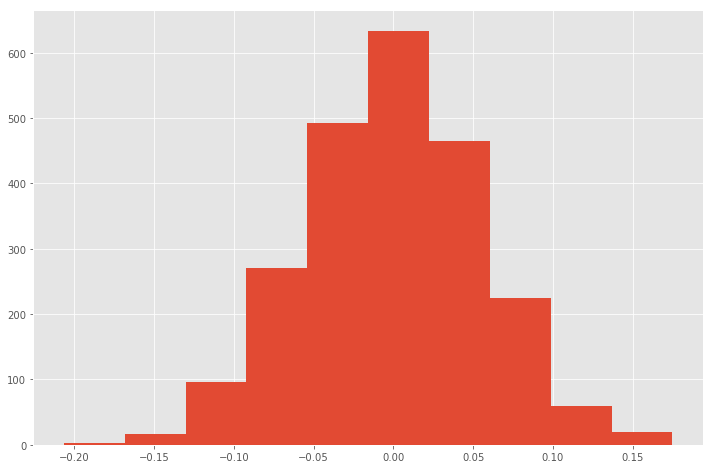

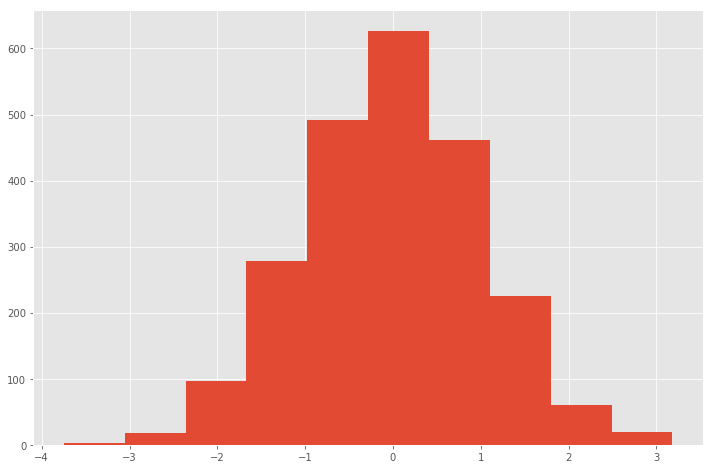

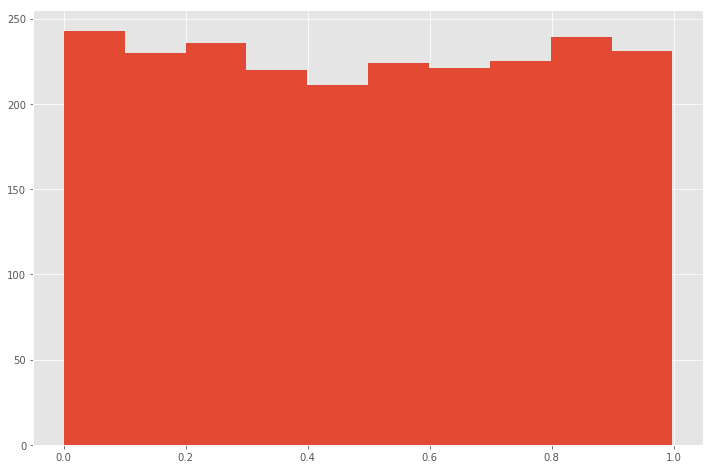

In [20]:
from scipy import stats

skew = stats.skew(residuals)
z, p = stats.skewtest(residuals)

plt.figure(figsize=(12, 8))
plt.hist(skew)
plt.show()


plt.figure(figsize=(12, 8))
plt.hist(z)
plt.show()

plt.figure(figsize=(12, 8))
plt.hist(p)
plt.show()

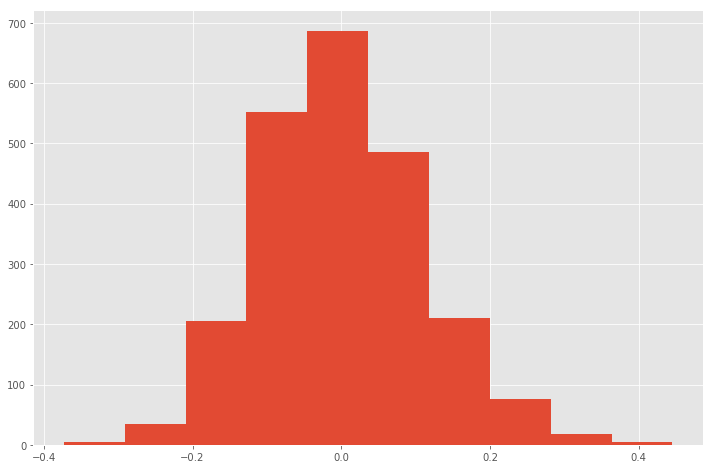

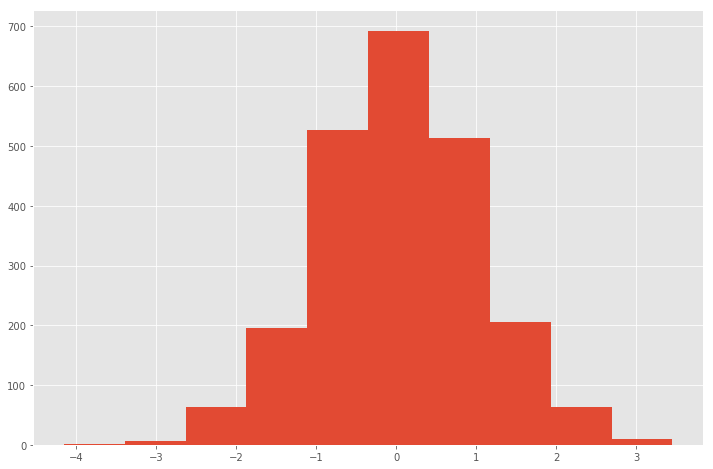

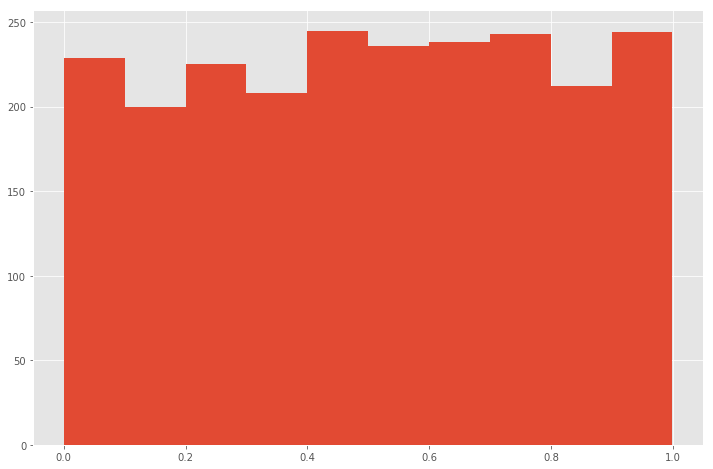

In [22]:
from scipy import stats

kurt = stats.kurtosis(residuals)
z, p = stats.kurtosistest(residuals)

plt.figure(figsize=(12, 8))
plt.hist(kurt)
plt.show()


plt.figure(figsize=(12, 8))
plt.hist(z)
plt.show()

plt.figure(figsize=(12, 8))
plt.hist(p)
plt.show()

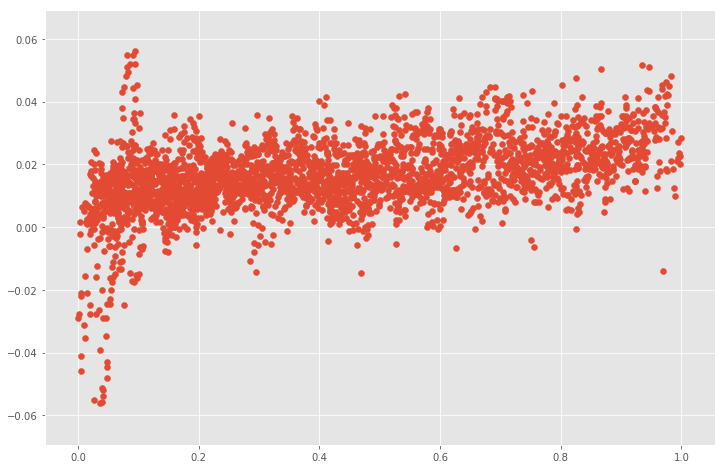

In [25]:
norm_y =  mauna_loa['norm_y'].as_matrix()
diff = [y - x for x, y in zip(norm_y, norm_y[52:])]


plt.figure(figsize=(12, 8))
plt.scatter(norm_y[52:], diff)
plt.show()

In [ ]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html

from sklearn.linear_model import Ridge, LassoLarsIC, LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

X = np.asarray(train['norm_day']).reshape(-1, 1)
y = np.asarray(train['norm_y'])

X_train = X[:-200]
y_train = y[:-200]
X_test = X[-200:]
y_test = y[-200:]

fig = plt.figure(figsize=(12, 8))
plt.plot(X_train, y_train, color='black')
plt.plot(X_test, y_test, color='red')

for count, degree in enumerate(range(1, 8)):
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) # LassoLarsIC(criterion='bic'))
    model.fit(X_train, y_train)
#     ic = np.sum(model.steps[1][1].criterion_)
    y_plot = model.predict(X)
    plt.plot(X, y_plot, lw=4, alpha=0.75,
             label='{d} degree, $R^2 = {r2:.4f}$'.format(d=degree, r2=model.score(X_test, y_test)))
#             label='{d} degree, $R^2 = {r2:.4f}$, ic = {ic:.3e}'.format(
#                 d=degree, r2=model.score(X_test, y_test), ic=ic))

plt.legend(loc=2, fontsize=12)